In [1]:
import fit_classes as fp
import numpy as np
import os
from scipy.interpolate import interp1d
from scipy import optimize

errors = []
ERROR = 2 # Error in mV

class DataPlus(fp.Data):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        def sinus_model(params, x):
            A,f,phi,c = params
            return A*np.sin(2*np.pi*f*x + phi) + c
        
        file = os.path.join(os.path.abspath(os.getcwd()), "data", "params.txt")
        name = str(self.name).split("\\")[-1]
        var = None
        vals = []
        with open(file, "r") as file:
            for line in file:
                vals.append((
                    line.strip().split(": ")[0],
                     tuple(map(float, line.strip().split(": ")[-1].strip("()").split(", ")))
                    ))

        check = False
        for var in vals:
            if var[0] == name:
                A, f, phi, c = var[1]
                check = True
                
        if check == False:
            A, f, phi, c = 100, 0.006, -13.06097, 25
            A = (np.abs(max(self.y)) + np.abs(min(self.y)))/2
            c = (max(self.y) + min(self.y))/2

            f_interp = interp1d(self.x, self.y, kind='cubic')
            x_dense = np.linspace(self.x.min(), self.x.max(), 1000)
            y_dense = f_interp(x_dense)

            crossings = []
            for i in range(len(x_dense)-1):
                if (y_dense[i] - c) * (y_dense[i+1] - c) < 0:  # Sign change
                    # Refine crossing with brentq
                    root = optimize.brentq(lambda x_val: f_interp(x_val) - c, x_dense[i], x_dense[i+1])
                    crossings.append(root)
                    # punt
                    # if self.x[list(self.x).index(punt) - 5] > self.x[list(self.x).index(punt) + 5]:
                    #     dalende_root.append(punt)

            
            # Find descending zero-crossings
            stijgende_root = []
            for i in range(len(self.y) - 2):
                if (self.y[i - 1] + self.y[i - 2])/2 < c and (self.y[i + 1] + self.y[i + 2])/2 >= c and self.x[i] > 10:
                    if stijgende_root != []:
                        if self.x[i] - stijgende_root[-1] > 10:
                            stijgende_root.append(self.x[i])
                    else:
                        stijgende_root.append(self.x[i])
            
            crossing_count = len(crossings)
            # crossing_count = crossing_count if crossing_count < 30 else 30
            # f = 0.00101048 if abs(len(crossings) - 21) < abs(len(crossings) - 42) else 0.00239959
            f = 0.002
            # phi  = -(stijgende_root[0]*f)*2*np.pi
            phi = np.pi/2 + 0.3
            # A = 8

        # phi = np.arcsin(self.x[0] / A)

        FIT_POINTS = 400
        SKIP_POINTS = 1

        self.x = self.x[:FIT_POINTS][::SKIP_POINTS]
        self.y = self.y[:FIT_POINTS][::SKIP_POINTS]
        self.dx = self.dx[:FIT_POINTS][::SKIP_POINTS]
        self.dy = self.dy[:FIT_POINTS][::SKIP_POINTS]

        self.fit = self.fit(sinus_model, initial_guess=(A, f, phi, c))
        self.fit.init = A, f, phi, c

        if check == False:
            file = os.path.join(os.path.abspath(os.getcwd()), "data", "params.txt")
            if self.fit.chi2_red < 10:
                values = (float(A), float(f), float(phi), float(c))
                with open(file, "a") as file:
                    file.write(f"{name}: {values}\n")


        self.A, self.f, self.phi, self.c = self.fit.minima

def data_from_file(file):
    file_path = os.path.join(os.path.dirname(os.path.abspath(os.getcwd())), file)
    data = np.genfromtxt(file_path, delimiter=",", skip_header=9)
    x = data[:, 0].astype(int)
    y = data[:, 1]
    mask = np.concatenate(([True], y[1:] != y[:-1]))
    x = x[mask]
    y = y[mask]

    dy = ERROR*np.ones_like(y)
    return DataPlus(x, y, dy, name=file_path)
        
def get_lowest_folders(root):
    lowest_folders = []
    for dirpath, dirnames, filenames in os.walk(root):
        if not dirnames:
            lowest_folders.append(dirpath)
    return lowest_folders

def load_data_by_folder(root):
    folder_data = {}
    total_files = 0
    for folder in get_lowest_folders(root):
        total_files += len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

    current_file = 0
    for folder in get_lowest_folders(root):
        folder_name = os.path.basename(folder)
        data_list = []
        for file in os.listdir(folder):
            file_path = os.path.join(folder, file)
            if os.path.isfile(file_path):
                current_file += 1
                # os.system(f'echo "File: {current_file:>3}/{total_files}"')
                data_list.append(data_from_file(file_path))
        
        if data_list:
            folder_data[folder_name] = np.array(data_list)
    return folder_data

data_arrays = load_data_by_folder(os.path.join(os.path.abspath(os.getcwd()), "data"))


# # print(data_arrays['opgave1'][0].show())
# print(f"{data_arrays['opgave1'][0].fit}")
# print(f"{data_arrays['opgave1'][0].f}")
# # print(f"{data_arrays['opgave1'][0].A}")
# # print(f"{data_arrays['opgave1'][0].w}")
# data_arrays['opgave1'][0].fit.show(size=2, fit_guess=True)
# print(f"{data_arrays['opgave5_freq2'][13].fit}")
# print(f"{data_arrays['opgave5_freq2'][13].f}")
# print('opgave4_freq1', '13')
# data_arrays['opgave4_freq1'][13].fit.show(size=2, fit_guess=True)
# print('opgave4_freq1', '14')
# data_arrays['opgave4_freq1'][14].fit.show(size=2, fit_guess=True)



In [2]:
# # # CAREFULL: THIS DISPLAYS 213 FITS!!!
# for key in data_arrays:
#     for i in range(len(data_arrays[key])):
#         print(key, i)
#         print("chi2_red:", data_arrays[key][i].fit.chi2_red)
#         print("minima:", data_arrays[key][i].fit.minima)
#         data_arrays[key][i].fit.show(size=2, fit_guess=True)

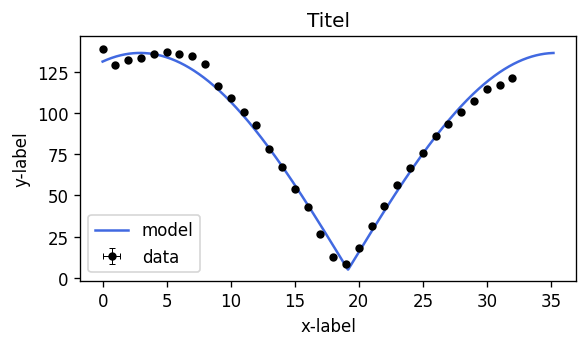

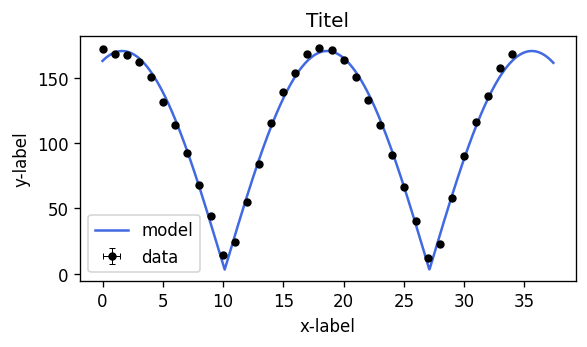

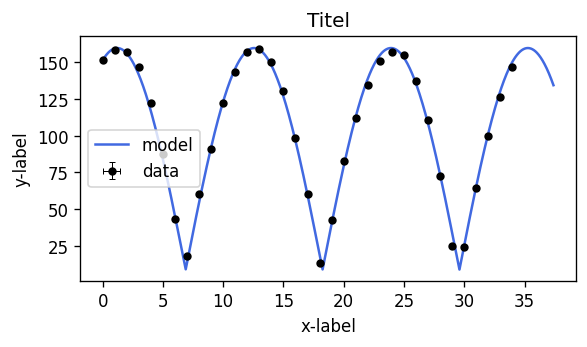

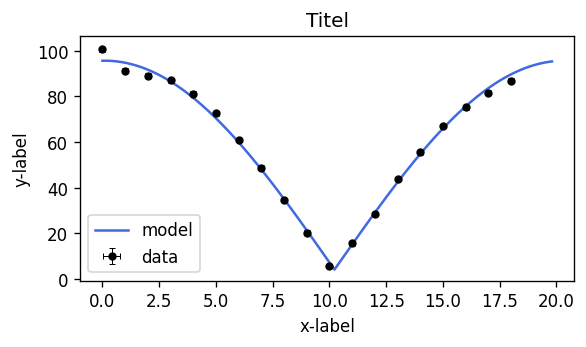

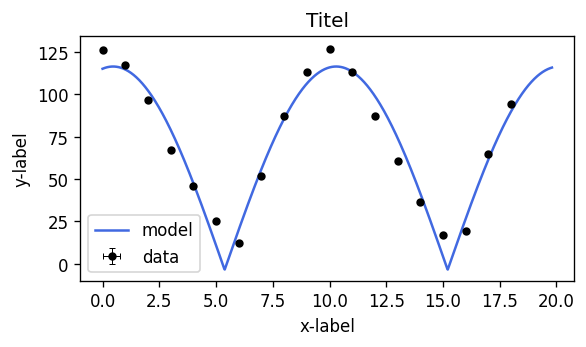

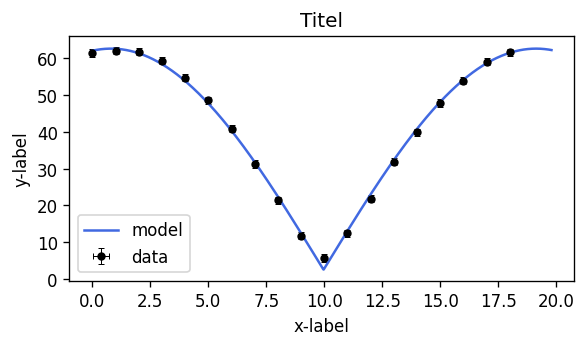

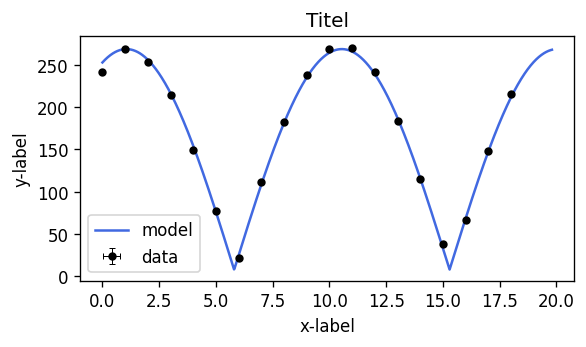

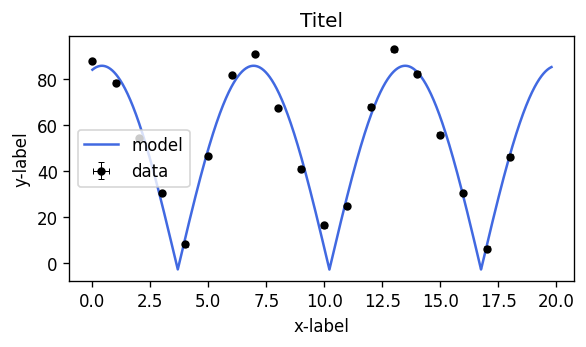

In [40]:
def sinus_model_abs(params, x):
    A,f,phi,c = params
    return np.abs(A*np.sin(2*np.pi*f*x + phi)) + c

names = ['opgave2_1', 'opgave2_2', 'opgave2_3', 'opgave4_freq1', 'opgave4_freq2', 'opgave5_freq1', 'opgave5_freq2', 'opgave5_freq3']
freqs = [0.013, 0.028, 0.04, 0.03, 0.05, 0.025, 0.05, 0.075]
for file, f in zip(names, freqs):
    x = [i for i in range(len(data_arrays[file]))]
    y = [data_arrays[file][i].A for i in range(len(data_arrays[file]))]
    dy = np.ones_like(y)
    dx = np.ones_like(x)*10
    opgave2_1_A = fp.Data(x, y, dy)
    A = max(y)
    phi = np.pi/2
    c = 0
    fitting = opgave2_1_A.fit(sinus_model_abs, initial_guess=(A, f, phi, c))
    fitting.show()